# Ejercicio 2: Regresión
_Felipe Andres Castillo_

In [1]:
#using Pkg
#Pkg.add("GLM")
#Pkg.add("Random")
using GLM
using Random

El conjunto de técnicas para construir y evaluar modelos que describen la relación entre variables, y para formular inferencias basadas en los modelos obtenidos se conocen colectivamente como **Técnicas de Regresión**, y al análisis estadístico que resulta de aplicarlas se le denomina **Análisis de Regresión**. 

En general, el análisis de regresión permite estudiar la influencia de una o más variables, que llamamos _independientes_, sobre otra que llamamos _dependiente_. Si se incluyen dos o más variables independientes se tiene un modelo de _Regresión multiple_, mientras que si se tiene una sola variable independiente se le denomina _Regresión simple_. Además, como primera aproximación, si entre todos los modelos posibles que pueden describir la relación entre variables se consideran exclusivamente los modelos llamados lineales, entonces hablamod de _Regresión Lineal Simple_ (o _Multiple)_. 

En el ejercicio anterior, se realizó un Análisis Exploratorio de Datos (EDA) del dataset _Bottle_, el cual contiene información oceanográfica del Océano Pacífico recopilada por el Programa de Investigaciones Cooperativas de Pesca Oceánica de California (CalCOFI).

Como resultado del EDA, se obtuvo un subconjunto de datos compuesto exclusivamente por variables cuantitativas, con un total de 17 variables y 602,434 registros.

In [2]:
include("./../src/exercise1_code.jl")
bottle_data = CSV.read("./../dat/bottle2.csv", DataFrame)
describe(bottle_data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,Depthm,158.221,0,110.0,558,0,Int64
2,T_degC,11.3381,3.95,10.54,23.023,0,Float64
3,Salnty,33.7749,32.464,33.772,35.102,0,Float64
4,O2ml_L,3.62925,-0.01,3.82,10.57,0,Float64
5,STheta,25.6944,22.818,25.8399,27.21,0,Float64
6,O2Sat,60.6956,-0.1,60.2,204.4,0,Float64
7,Oxy_µmol/Kg,158.098,-0.4349,166.276,461.299,0,Float64
8,R_Depth,158.221,0.0,110.0,558.0,0,Float64
9,R_TEMP,11.3382,3.95,10.54,23.02,0,Float64


En este ejercicio, nos enfocaremos en la variable **T_degC**, que representa la temperatura del agua en grados Celsius. El objetivo es identificar el conjunto de variables independientes que, al aplicar un análisis de regresión lineal, permita obtener la mejor predicción de dicha variable.

### Selección de variables independientes

Como primer paso se tiene el elegir el conjunto de variables predictoras. Para ello utilizaremos la matriz de correlación obtenida en el EDA, para así identificar aquellas variables que tengan un alto indice de asociación, ya sea positiva o negativa.  

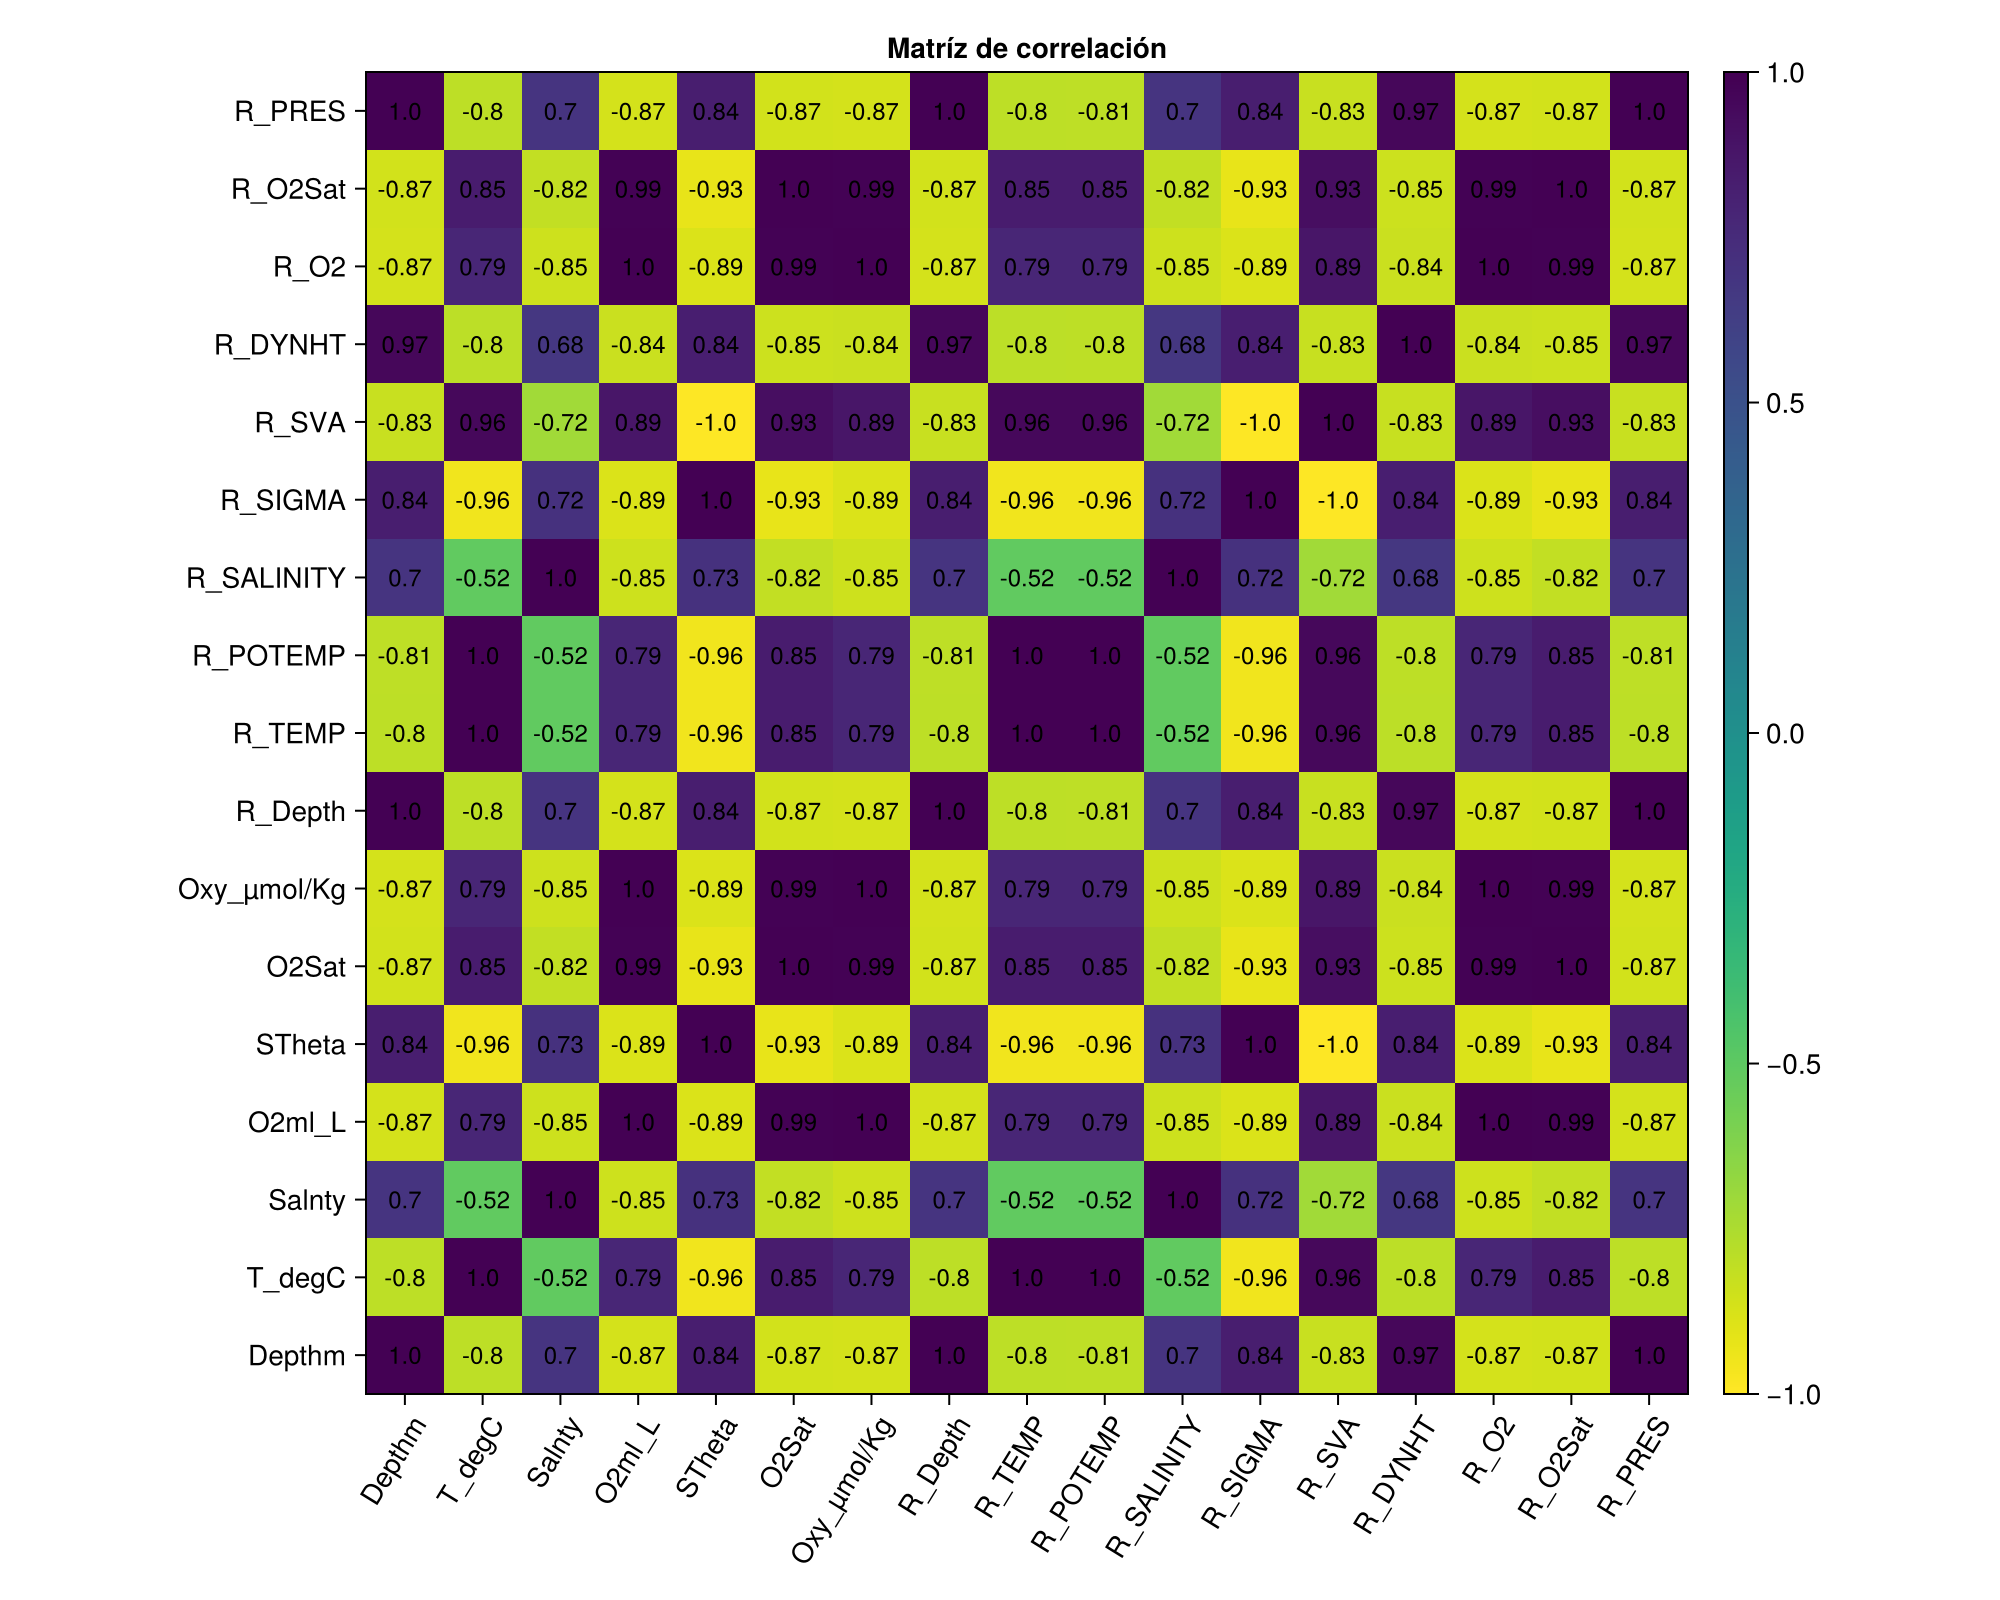

In [3]:
displayCorrelation(bottle_data)

De acuerdo a la imagen, **T_degC** presenta, por ejemplo, un indice alto de correlación positiva con las variables:
1. **R_TEMP**: Temperatura (in situ) reportada en grados Celsius
2. **R_POTEMP**: Temperatura (potencial) reportada en grados Celsius 

También se presenta un alto indice de correlación negativa con las variables:
1. **STheta**: Densidad (potencial) del agua
2. **R_SIGMA**: Densidad (potencial) reportada

En general, todas las variables presentan altos indices de correlación con **T_degC**. 

Es importante destacar que las variables en el dataset se dividen en dos grupos principales. Por un lado, están las variables _reportadas_, que se identifican con una "R" al inicio del nombre. Estas representan los valores iniciales o brutos obtenidos directamente de los instrumentos de medición, como sensores o sondas CTD, durante las mediciones en campo. Por otro lado, están las mismas variables, pero en su versión final o "validada", cuyos datos han sido procesados y son considerados más precisos para análisis científicos.

Por esta razón, en casos como el de **STheta** y **R_SIGMA**, se elegirá STheta para los análisis, ya que corresponde a los datos validados. Asimismo, aunque **R_TEMP** y **R_POTEMP** presentan los valores más altos de correlación con **T_degC**, esto se debe a que ambas son las variables reportadas de la variable dependiente **T_degC**. Por lo tanto, no serán consideradas como variables independientes en el modelo de regresión.

Entonces quedan las variables: 
1. **Depthm**: Profundidad del _bottle_ en metros
2. **Salnty**: Salinidad
3. **O2ml_L**: Mililitros de oxígeno por litro de agua de mar
4. **O2Sat**: Porcentaje de saturación de oxígeno
5. **Oxy_$\mu$mol/Kg**: Micromoles de oxígeno por kilogramo de agua de mar
6. **STheta**: Densidad (potencial) del agua
7. **R_SVA**: Anomalía de Volumen Específico (_Specific-Volume Anomaly_, SVA). Es la diferencia entre el volumen específico real de agua de mar y el volumen específico de agua de mar a una presión, temperatura y salinidad específicas.

Una clara observación adicional que se obtiene del heatmap es que las anteriores variables también están correlacionadas entre sí. En el caso de las variables relacionadas al oxigeno, las tres son casi equivalentes por lo que sólo se elegirá una. 

In [4]:
#Gráficas

In [5]:
# df = bottle_data[rand(1:size(bottle_data, 1), 5000), :];
# fig = Figure(size=(1000, 800))
# ax = Axis(
#     fig[1,1], 
#     title = "Correlación", 
#     xlabel = "T_degC",
#     ylabel = "Depthm"
# )
# pltobj = scatter!(ax, df.T_degC, df.Depthm; color = :blue)
# fig
# #colsize!(fig.layout, 1, Aspect(1, 1.0))

Lo siguiente es dividir nuestro conjunto de datos en dos subconjuntos: el de **entrenamiento (70%) y el de prueba (30%)**.

In [6]:
Random.seed!(18)

#Número total de registros
rows, = dataShape(bottle_data)
#Muestra aleatoria de indices para los datos de entrenamiento (70% de los datos)
rows_train = sample(1:rows, Int(round(0.7*rows)), replace = false)
#Indices restantes para los datos de prueba
rows_test = Not(rows_train)

#Datos entrenamiento
data_train = bottle_data[rows_train,:]
#Datos prueba
data_test = bottle_data[rows_test,:];

### Construcción y evaluación de modelos

Métricas de evaluación: 
1. **p-value**: Se dice que una variable en un módelo de regresión lineal es estadisticamente significativa solo si el valor de **p** es menor a un nivel predeterminado de significancia estadistica, el cual es usualmente 0.05.
   
2. $R^2_{adj}$: El coeficiente de determinación $R^2$ mide la proporción de la varianza de la variable dependiente que el modelo es capaz de explicar. En otras palabras, indica qué tan bien se ajusta un modelo de regresión a los datos observados. Sin embargo, en modelos de regresión lineal múltiple, el valor de $R^2$ tiende a aumentar a medida que se añaden más predictores al modelo, ya que cada predictor, por pequeño que sea su impacto, contribuye a explicar parte de la variabilidad de la variable dependiente. Por esta razón, $R^2$ no es adecuado para comparar modelos con distinto número de predictores.

   En su lugar, se utiliza el coeficiente de determinación ajustado ($R^2_{adj}$), que introduce una penalización al valor de $R^2$ por cada predictor adicional incluido en el modelo. Este coeficiente puede variar entre $-1$ y $1$. Un $R^2_{adj}$ negativo indica que el modelo ajustado es peor que un modelo nulo, lo que sugiere que no es adecuado y podría estar sobreajustado. Un $R^2_{adj}$ cercano a 1 implica que el modelo explica muy bien la variabilidad de la variable dependiente, teniendo en cuenta tanto la complejidad del modelo como el número de predictores.
$$R^2_{adj} = R^2 - (1-R^2)\frac{n-1}{n-k-1}$$ donde $n$ es el tamaño de la muestra y $k$ el número de predictores introducidos en el modelo.

3. **MSE** (_Mean Squared Error_): El error cuadrático medio de un estimador mide el promedio de los errores al cuadrado, es decir, la diferencia entre el estimador y lo que se estima. Esta métrica es muy útil para saber que tan cerca es la línea de ajuste de nuestra regresión a las observaciones. Siempre es positivo y entre más cercano sea a cero es mejor.

   $$ MSE = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y}_i)^2$$
donde $y_i$ respresenta al valor observado y $\hat{y}_i$ es el valor predicho.

4. **RMSE** (_Root Mean Square Error_): Es la raíz cuadrada del valor del MSE. La ventaja es que se obtiene un valor en las unidades originales y no en unidades cuadradas.

#### Modelo 1

Variables independientes: **Depthm, Salnty, O2ml_L, STheta, R_SVA**

In [7]:
fx1 = @formula(T_degC ~ Depthm + Salnty + O2ml_L + STheta + R_SVA)
model_1 = lm(fx1, data_train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

T_degC ~ 1 + Depthm + Salnty + O2ml_L + STheta + R_SVA

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                    Coef.   Std. Error        t  Pr(>|t|)     Lower 95%      Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)  -763.244      1.41595      -539.03    <1e-99  -766.019      -760.469
Depthm         -0.0065618  8.05982e-6   -814.14    <1e-99    -0.0065776    -0.00654601
Salnty          3.46408    0.00136196   2543.46    <1e-99     3.46141       3.46675
O2ml_L          0.0534298  0.000475539   112.36    <1e-99     0.0524978     0.0543619
STheta         22.9998     0.0507822     452.91    <1e-99    22.9003       23.0994
R_SVA           0.290996   0.000533958   544.98    <1e

Modelo: $$T_{degC} = -0.0065618\cdot Depthm + 3.46408 \cdot Salnty + 0.0534298 \cdot O2ml\_L + 22.9998 \cdot STheta + 0.290996 \cdot R\_SVA -763.244 $$
1. **p-value**: En este caso todas, el valor p de todas las variables es menor a 0.05, por lo que sí son variables significantes para predecir T_degC

### Modelo 2

Variables: **Depthm, Salnty, O2Sat, R_SVA**

In [8]:
fx2 = @formula(T_degC ~ Depthm + Salnty + O2Sat + STheta + R_SVA)
model_2 = lm(fx2, data_train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

T_degC ~ 1 + Depthm + Salnty + O2Sat + STheta + R_SVA

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                     Coef.   Std. Error        t  Pr(>|t|)      Lower 95%      Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)  -773.691       1.41907      -545.21    <1e-99  -776.472       -770.909
Depthm         -0.00664405  7.92595e-6   -838.27    <1e-99    -0.00665959    -0.00662852
Salnty          3.44874     0.00124946   2760.19    <1e-99     3.44629        3.45118
O2Sat           0.00364972  2.92199e-5    124.91    <1e-99     0.00359245     0.00370699
STheta         23.3923      0.0508703     459.84    <1e-99    23.2926        23.492
R_SVA           0.294732    0.000534359

Modelo: $$T_{degC} = -0.00664405\cdot Depthm + 3.44874 \cdot Salnty + 0.00364972 \cdot O2Sat + 23.3923 \cdot STheta + 0.294732 \cdot R\_SVA -773.691 $$
1. **p-value**: En este caso todas, el valor p de todas las variables es menor a 0.05, por lo que sí son variables significativas para predecir T_degC

#### Modelo 3

Variables independientes: **Depthm, Salnty, O2ml_L, STheta**

In [9]:
fx3 = @formula(T_degC ~ Depthm + Salnty + O2ml_L + STheta)
model_3 = lm(fx3, data_train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

T_degC ~ 1 + Depthm + Salnty + O2ml_L + STheta

Coefficients:
───────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error         t  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────
(Intercept)   7.91535     0.0668328      118.44    <1e-99   7.78436      8.04634
Depthm       -0.00281957  5.5092e-6     -511.79    <1e-99  -0.00283037  -0.00280877
Salnty        3.66512     0.00171156    2141.39    <1e-99   3.66176      3.66847
O2ml_L        0.0385657   0.000619788     62.22    <1e-99   0.0373509    0.0397804
STheta       -4.67261     0.000944019  -4949.70    <1e-99  -4.67446     -4.67076
───────────────────────────────────────────────────────────────────────────────────

Modelo: $$T_{degC} = -0.00281957\cdot Depthm + 3.66512 \cdot Salnty + 0.0385657 \cdot O2ml\_L -4.67261 \cdot STheta + 7.91535$$
1. **p-value**: En este caso todas, el valor p de todas las variables es menor a 0.05, por lo que sí son variables significantes para predecir T_degC

#### Predicciones y evaluación 

In [11]:
#Esta función calcula la raíz cuadrada del error cuadrático medio de una variable estimada por regresión lineal
function rmse(observed_y, predicted_y)
    return sqrt(mean( (observed_y-predicted_y).^2 ))
end

#Esta función obtiene la predicción de la variable dependiente dado un conjunto de datos y un modelo de regresión;
#también determina el coeficiente de determinación ajustado (R^2_adj) y el RMSE
function predict_evaluate(model, data, y_observed)
    prediction = predict(model, data)
    r2a = adjr2(model)
    rmse_val = rmse(y_observed, prediction)
    return prediction, r2a, rmse_val
end

predict_evaluate (generic function with 1 method)

In [12]:
model = [model_1, model_2, model_3]
variables = []
R2adj = []
RMSE_data_train = []
RMSE_data_test = []

for mod in model
    r_train = predict_evaluate(mod, data_train, data_train.T_degC)
    r_test = predict_evaluate(mod, data_test, data_test.T_degC)
    push!(variables, mod.mf.f.rhs)
    push!(R2adj, r_train[2])
    push!(RMSE_data_train, r_train[3])
    push!(RMSE_data_test, r_test[3])
end

DataFrame(Predictores = variables, R2adj = R2adj, RMSE_data_train = RMSE_data_train, RMSE_data_test = RMSE_data_test)

Row,Predictores,R2adj,RMSE_data_train,RMSE_data_test
,Any,Any,Any,Any
1,1 + Depthm + Salnty + O2ml_L + STheta + R_SVA,0.997559,0.187209,0.234671
2,1 + Depthm + Salnty + O2Sat + STheta + R_SVA,0.997576,0.18657,0.235284
3,1 + Depthm + Salnty + O2ml_L + STheta,0.99584,0.244399,0.245016


En los tres casos evaluados, el coeficiente de determinación es cercano a 1, con el segundo modelo mostrando un rendimiento ligeramente superior.

En cuanto al valor de la raíz del error cuadrático medio (RMSE) para los datos de entrenamiento, se obtienen mejores resultados al incorporar la variable R_SVA. Además, no se observa una diferencia significativa al intercambiar las variables O2ml_L y O2Sat.

Para el RMSE asociado a los datos de prueba, los tres modelos presentan valores similares, aunque el primer modelo muestra un desempeño ligeramente mejor.

#### Cross Validation

Una pregunta clave es: ¿qué tan bien puede el modelo hacer predicciones en datos que no ha visto antes? Aunque la evaluación con el conjunto de prueba proporciona una referencia, esta evaluación está condicionada por la distribución particular de los datos entre los conjuntos de entrenamiento y prueba.

Para abordar esta limitación, se utiliza la validación cruzada (_cross-validation_), una técnica diseñada para evaluar el rendimiento de un modelo asegurando que los resultados sean independientes de cómo se dividen los datos. La idea central es sencilla: en lugar de depender de una única partición entre conjuntos de entrenamiento y prueba, la validación cruzada utiliza todos los datos disponibles.

El método más común es el de _k-fold cross-validation_, que funciona de la siguiente manera:
1. Los datos se dividen en K subconjuntos (o folds).
2. En cada iteración, uno de los subconjuntos se usa como conjunto de prueba, mientras que los restantes (k-1) se utilizan para entrenar el modelo.
3. Este proceso se repite K veces, alternando el subconjunto utilizado como datos de prueba en cada iteración.
4. Finalmente, se calcula la media aritmética de las métricas obtenidas en cada iteración para producir un único resultado, que refleja el desempeño general del modelo.

Este enfoque garantiza que todas las observaciones se utilicen tanto para el entrenamiento como para la validación, proporcionando una evaluación más robusta y confiable.

In [36]:
function cross_validation(data, fx, k)
    #Se mezclan aleatoriamente los registros, garantizando que el orden en el que presentemos los datos no afectará el desempeño del modelo
    df_shuffle = shuffle(data)
    #Se determina el tamaño del set de datos de validación según el tamaño de todo el dataframe y el valor de k
    val_size = Int(ceil(size(data)[1]/k))
    RMSE_val = []
    RMSE_train = []
    for n in 0:k-1
        start_idx = 1 + n * val_size
        final_idx = min(start_idx + val_size - 1, size(data)[1])
        #Datos de validación
        data_val = df_shuffle[start_idx:final_idx,:]
        #Datos entrenamiento
        data_train = df_shuffle[Not(start_idx:final_idx),:]
        #Modelo
        model = lm(fx, data_train)
        #Predicción y evaluación
        r_val = predict_evaluate(model, data_val, data_val.T_degC)
        push!(RMSE_val, r_val[3])
        r_train = predict_evaluate(model, data_train, data_train.T_degC)
        push!(RMSE_train, r_train[3])
    end
    push!(RMSE_val, mean(RMSE_val))
    push!(RMSE_train, mean(RMSE_train))
    return DataFrame(k_set = range(1,k)∪["promedio:"], RMSE_train = RMSE_train, RMSE_validation = RMSE_val)
end      

cross_validation (generic function with 1 method)

**Cross validation del primer modelo**

In [38]:
cross_validation(bottle_data, fx1, 10)

Row,k_set,RMSE_train,RMSE_validation
,Any,Any,Any
1,1,0.200545,0.192054
2,2,0.20076,0.190043
3,3,0.200677,0.190834
4,4,0.187281,0.308114
5,5,0.200813,0.189525
6,6,0.200848,0.189179
7,7,0.200883,0.188838
8,8,0.200627,0.191306
9,9,0.200716,0.190469


**Los resultados indican que el desempeño del modelo 1 es muy similar tanto durante el entrenamiento como en la validación, lo que permite concluir que no presenta sobreajuste. Además, esto sugiere que el modelo es capaz de generalizar adecuadamente y hacer predicciones consistentes con datos nuevos.**